# Clustering of Luxembourg

## PROBLEM STATEMENT

    In this work we are going to conduct cluster analysis of Luxembourg. It is a small country in the western Europe, landlocked between Belgium, France and Germany. Its population amounts to 590 000 as of 1- Jan-2017. Despite of the small size, it is quite a developed country and it attracts lot of foreigners, such as tourists, expats and cross-border workers. 
    We will collect information about Luxembourg communes, draw these on the map and conduct cluster analysis based on venues in these communes, in order to classify them such in terms of touristic/leisure/culture areas. Having the clusters reflected on a map, it would be easier for one to understand where to go for a weekend, or for a longer rest, or stay during a business trip. Also, the obtained information could provide a view to quickly understand what area of the country or even a commune would represent an interest for a visit/trip/stay/live.


## DATA USED, AND THE APPROACH APPLIED

    For the analysis, we use data files publicly available on Luxembourg data portal. The file exposes information about all the communes in Luxembourg, their population as of 1/1/2017, and geolocation. Also, in order to repartition the largest city, Ville de Luxembourg, on districts, in order to have this comparable with smaller communes, we will use another publicly available data file shared on the same data portal. Additionally, we would need to use Geocoder API in order to obtain geolocations of the districts. 
    We are going to use Foursquare API for the determination of TopPicks venues available in the locations and nearby. Due to high density of communes in this small country, we selected 1km radius as appropriate, trying to avoid an overlap between neighboring communes. Also, from the point of view of a visitor, 1km is a relevant radius where he could go by step without too much efforts.  
    Having this information, we will conduct cluster analysis of the communes and, as a result, get different clusters of Luxembourg communes mapped in on a chart in different colors. We will also analyze most used venues in the clusters and will try to provide description of distinctions among the clusters.

#### Load communities geolocation from publicly open dataset

In [6]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from   sklearn.cluster import KMeans

In [86]:
# get list of luxembourg communes from publicly available data file
!wget -q -O "lux_communes.xls" https://data.public.lu/en/datasets/r/a7d551d7-f374-491a-ab93-63715b98e6dd
luxdata = pd.read_excel(io="lux_communes.xls", sheet_name ="Sheet1")
luxdata = luxdata[luxdata["LOCALITE_OFFICIELLE"] == 'OUI']
luxdata = luxdata[np.logical_not(np.isnan(luxdata["LON_LL84"]))]

In [87]:
luxdata.head()

,NOM_COMMUNE_ADMINISTRATIVE,NOM_COMMUNE_CADASTRALE,NOM_OFFICIEL_LOCALITE,LOCALITE_OFFICIELLE,NOM_LUXEMBOURGEOIS (svt. CPLL),Y_RECHTS,X_HOCH,LON_LL84,LAT_LL84,Unnamed: 9,localité officielle = issue du registre national des localités et des rues,CPLL = Conseil permanent de la langue luxembourgeoise
0,Bettembourg,Bettembourg,Abweiler,OUI,Obeler,73578.0,66589.0,6.079404,49.533972,NaN,NaN,NaN
3,Wormeldange,Wormeldange,Ahn,OUI,Ohn,98328.0,76929.0,6.421799,49.626693,NaN,NaN,NaN
6,Wincrange,Oberwampach,Allerborn,OUI,Allerbuer,58773.0,122538.0,5.871837,50.036652,NaN,NaN,NaN
9,Kiischpelt,Kautenbach,Alscheid,OUI,Alschent,68385.0,115157.0,6.006226,49.970558,NaN,NaN,NaN
10,Junglinster,Junglinster,Altlinster,OUI,Allënster,83286.0,87411.0,6.213694,49.721206,NaN,NaN,NaN


We will select only columns which repreent interest for us: NOM_OFFICIEL_LOCALITE,LAT_LL84,LON_LL84 which are Official commune name, lattitude and longtidute correspondigly.

In [88]:
# The code was removed by Watson Studio for sharing.

,Commune,Latitude,Longitude
0,Abweiler,49.533972,6.079404
3,Ahn,49.626693,6.421799
6,Allerborn,50.036652,5.871837
9,Alscheid,49.970558,6.006226
10,Altlinster,49.721206,6.213694


In [89]:
luxdata.reset_index(inplace=True, drop=True)
luxdata.tail(5)

,Commune,Latitude,Longitude
560,Wolper,49.765362,6.354330
561,Wolwelange,49.828933,5.766363
562,Wormeldange,49.611944,6.402627
563,Wormeldange-Haut,49.611944,6.402627
564,Zittig,49.745253,6.346538


In [91]:
#some data cleaning and tidying
lcg=luxdata.groupby("Commune").count()
luxdata[luxdata.Commune.isin(lcg[lcg.Latitude > 1].index)]

,Commune,Latitude,Longitude
123,Dirbach,49.921176,6.036719
124,Dirbach,49.921176,6.036719
163,Eschweiler,49.997625,5.944643
164,Eschweiler,49.716449,6.312917
218,Grundhof,49.833942,6.331674
219,Grundhof,49.833942,6.331674
262,Hostert,49.809106,5.869848
263,Hostert,49.655472,6.235707
353,Merscheid,49.871631,5.968509
354,Merscheid,49.954730,6.102845


In [92]:
luxdata.drop(index=[124,219], inplace=True)
for i in [163,262,353,539]: luxdata.loc[i, "Commune"] = luxdata.loc[i, "Commune"].upper()
luxdata.reset_index(inplace=True, drop=True)
print("The number of communes is ", luxdata.shape[0])

The number of communes is  563


In [13]:
#install folium library for Map rendering
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [14]:
# The code was removed by Watson Studio for sharing.

We notice that Luxembourg-ville is the largest city in the country, and we want to split it on the districts in our analysis, in order to consider each district separately as this could improve quality of our examination. Data for the Luxembourg-ville are also available in Luxembourg data portal.

In [93]:
url = project.get_file("popcom2000-2017_LAU2.xlsx")
vdldata=pd.read_excel(io=url, sheet_name="Luxembourg-ville")
vdldata = vdldata.iloc[0:-1, 0:1]
vdldata.columns = ["Commune"]
vdldata

,Commune
0,BEGGEN
1,BELAIR
2,BONNEVOIE-NORD/VERLORENKOST
3,BONNEVOIE-SUD
4,CENTS
5,CESSANGE
6,CLAUSEN
7,DOMMELDANGE
8,EICH
9,GARE


In [16]:
print("Number of Luxembourg-ville districts is", vdldata.shape[0])

Number of Luxembourg-ville districts is 24


We add geolocation coordinates to each of the commune, making use of *geopy.geocoders* library

In [94]:
geolocator = Nominatim(user_agent="my-application")
vdldata["Latitude"] = ""
vdldata["Longitude"] = ""

for idx in vdldata.index:
    address = vdldata.loc[idx, "Commune"] + ", LU"
    #print(address)
    loc1 = geolocator.geocode(address)
    lat1 = loc1.latitude
    lon1 = loc1.longitude
    vdldata.loc[idx, "Latitude"] = lat1
    vdldata.loc[idx, "Longitude"] = lon1
    
vdldata

,Commune,Latitude,Longitude
0,BEGGEN,49.6429,6.1296
1,BELAIR,49.6115,6.10792
2,BONNEVOIE-NORD/VERLORENKOST,49.6031,6.13988
3,BONNEVOIE-SUD,49.5986,6.13559
4,CENTS,49.6164,6.16211
5,CESSANGE,49.5857,6.09569
6,CLAUSEN,49.6144,6.14308
7,DOMMELDANGE,49.6424,6.14339
8,EICH,47.1571,8.16931
9,GARE,49.6037,6.12767


We join Luxembourg communities and districts of Luxembourg-ville

In [95]:
luxdata=luxdata.append(vdldata, ignore_index=True)
luxdata=luxdata[luxdata.Commune != "Luxembourg"]

In [96]:
print("Total number of communes is ", luxdata.shape[0])

Total number of communes is  586


### Map Luxembourg comminities

In [20]:
# The code was removed by Watson Studio for sharing.

In [21]:
address = 'Luxembourg'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Luxembourg is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Luxembourg is 49.8158683, 6.1296751.


In [97]:
map_lux = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
#for lat, lng, community, population in zip(luxpop['Latitude'], luxpop['Longtitude'], luxpop['Community'], luxpop["Population"]):
for lat, lng, community in zip(luxdata['Latitude'], luxdata['Longitude'], luxdata['Commune']):
#    label = '{} {}'.format(community, population)
    label = '{}'.format(community)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lux)  
    
map_lux

In [271]:
def getNearbyVenues(locality, latitudes, longitudes, section, radius=1000):
    
    venues_list=[]
    for locality, lat, lng in zip(locality, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}&section={}&radius={}&sortByDistance=1'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat,
            lng,
            LIMIT,
            section,
            radius
        )
            
        # make the GET request
        res = requests.get(url).json()
        if (res['meta']['code'] == 200):
            if (res['response']['totalResults'] > 0):
                #print(locality, " ", res['response']['totalResults'])
                results = res['response']['groups'][0]['items']
        # return only relevant information for each nearby venue
                venues_list.append([(
                    locality, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) for v in results])
            else:
                print(locality)
 
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Locality', 
                  'Locality Latitude', 
                  'Locality Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [196]:
#frequency matrix per venue type per community
def createFreqMatrix(luxv):
    luxv["Val"] = 1
    tpiv=pd.pivot_table(luxv, values="Val", columns="Venue Category", aggfunc=np.sum, index=["Locality"])
    tpiv=tpiv.fillna(0)
    tpiv['venues_distinct'] = tpiv.astype(bool).sum(axis=1)
    tpiv["venues_qty"] = tpiv.iloc[:,:-1].sum(axis=1)
    for i in range(tpiv.shape[1]-2):
        tpiv.iloc[:, i]=tpiv.iloc[:, i]/tpiv.iloc[:, -1]

    tpiv.drop(["venues_qty", 'venues_distinct'],axis=1,inplace=True)   
    return(tpiv)

In [202]:
#create dataframe with 10 most popular venue types per commune
def ShowTop10Venues(tab_section):
    dict={}
    for i in range(tab_section.shape[0]):
        t=tab_section.iloc[i,:]
        t=t[t>0].sort_values(ascending=False)
        dict[i]={"Commune": t.name}
        for j in range(0, min(10, t.size)):
            dict[i].update({"Venue " + str(j+1): t.index[j]})
    tab_output = pd.DataFrame(dict).transpose().iloc[:, [0,1,3,4,5,6,7,8,9,10,2]].fillna("")        
    return(tab_output)

In [221]:
## function for rendering geo map of clusters with round markers and popup frames
def render_cluster_Map(kclusters, tab_section, lux_venues):
#some preparation of data

    tt = pd.DataFrame([tab_section.index, tab_section.iloc[:,-1]]).transpose()
    tt.columns=["Commune",'cluster']
    lux_clustered=pd.merge(luxdata, tt, how='right', on="Commune", suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

# create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)#, tiles = "Stamen Terrain")

# set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i+x+(i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

#for each commune, a Popup will appear as IFrame with the table of venues
    for lat, lon, poi, cluster in zip(lux_clustered['Latitude'], lux_clustered['Longitude'], lux_clustered['Commune'], lux_clustered['cluster']):
        lv = lux_venues[(lux_venues["Locality"] == poi) & (lux_venues["Locality Latitude"] == lat)]
        html="<h3>" + poi + "/ Cluster " + str(cluster) + "</h3>"
        html = html + "<table border>"
        html = html + "<tr><th>Venue</th><th>Venue Category</th></tr>"
    
        for (vname, vlat, vlon, vcat) in zip(lv["Venue"], lv["Venue Latitude"], lv["Venue Longitude"], lv["Venue Category"]):
            html = html + "<tr><td><FONT FACE='Arial' SIZE=2>" + vname.replace('"', "'") + "</FONT></td><td><FONT FACE='Arial' SIZE=2>" + vcat + "</FONT></td></tr>"
        html = html + "</table>"    
        iframe = folium.IFrame(width=400, height=200, html = html)
        ipopup = folium.Popup(iframe, max_width=2650)
        folium.CircleMarker(
            [lat, lon],
            radius=3,
            popup= ipopup,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return(map_clusters)


In [147]:
def gettop10venues(lux_venues, cluster_labels):
#create dataframe with 10 most popular venue types per cluster
    lux_venues["Val"] = 1
    tab1=pd.pivot_table(lux_venues, values="Val", columns="Venue Category", aggfunc=np.sum, index=["Locality"])
    tab1=tab1.fillna(0)
    tab1["cluster"] = cluster_labels #kmeans.labels_

    tabcl=tab1.groupby('cluster').sum()
    dictcl={}
    for i in range(tabcl.shape[0]):
        tt=tabcl.iloc[i,:]
        tt=tt[tt>0].sort_values(ascending=False)
        dictcl[i]={"Cluster": tt.name}
        for j in range(0, min(10, tt.size)):
            dictcl[i].update({"Venue " + str(j+1): tt.index[j]})
        
    cluster_most_venues = pd.DataFrame(dictcl).fillna("").iloc[[1,3,4,5,6,7,8,9,10,2]]
#cluster_most_venues = pd.DataFrame(dictcl).fillna("").iloc[[1,2, 3]]
    new_columns =  ["Cluster " + str(i) for i in range(len(cluster_most_venues.columns))]
    cluster_most_venues.columns = new_columns
    return(cluster_most_venues)

### Clustering of Outdoors venues in Luxembourg communes

In [ ]:
#fill in venues in radius 1km for each commune, limited by LIMIT number per commune
lux_venues_outdoors = getNearbyVenues(luxdata.Commune, luxdata.Latitude, luxdata.Longitude,'outdoors',radius = 1000)
### frequency matrix per Outdoors venues
tab_outdoors = createFreqMatrix(lux_venues_outdoors)

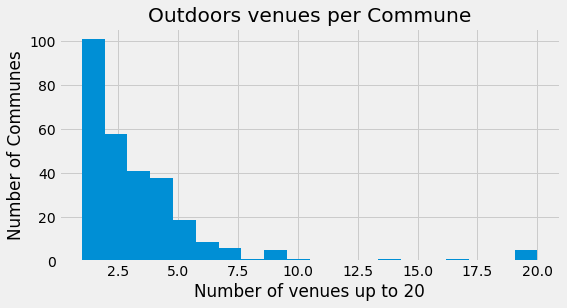

In [99]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(lux_venues_outdoors.groupby("Locality").count()["Venue"], bins=20)
#labels = ax.get_xticklabels()
plt.style.use('fivethirtyeight')
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.set(title = "Outdoors venues per Commune", xlabel = "Number of venues up to 20", ylabel = "Number of Communes")
plt.show()

In [278]:
print("Number of outdoors venues identified: %d" %(lux_venues_outdoors.shape[0]))
lux_venues_outdoors.head()

Number of outdoors venues identified: 877


,Locality,Locality Latitude,Locality Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Val
0,Alzingen,49.570519,6.165731,Parc de Hesperange,49.571596,6.158094,Sculpture Garden,1
1,Alzingen,49.570519,6.165731,Camping Alzingen,49.569686,6.159213,Campground,1
2,Alzingen,49.570519,6.165731,Beach Club,49.570400,6.158370,Beach,1
3,Alzingen,49.570519,6.165731,Centre Sportif Holleschberg,49.575859,6.157766,Soccer Field,1
4,Bascharage,49.568896,5.903369,Kaerjenger Dribbel,49.562716,5.904908,Soccer Field,1


In [102]:
print('There are {} uniques outdoors venue categories.'.format(len(lux_venues_outdoors['Venue Category'].unique())))

There are 54 uniques outdoors venue categories.


#### Select Top 10 popular Outdoors venue types per commune

In [203]:
ShowTop10Venues(tab_outdoors).head()

,Commune,Venue 1,Venue 2,Venue 3,Venue 4,Venue 5,Venue 6,Venue 7,Venue 8,Venue 9,Venue 10
0,Alzingen,Soccer Field,Sculpture Garden,Campground,Beach,,,,,,
1,BEGGEN,Gym,Soccer Field,,,,,,,,
2,BELAIR,Plaza,Gym / Fitness Center,Playground,Park,,,,,,
3,BONNEVOIE-NORD/VERLORENKOST,Plaza,Sculpture Garden,Park,Gym,Athletics & Sports,Trail,Skate Park,Gym Pool,Gym / Fitness Center,Garden
4,BONNEVOIE-SUD,Plaza,Gym,Athletics & Sports,Skate Park,Sculpture Garden,Park,Gym Pool,Gym / Fitness Center,Garden,


#### K-Means Clustering of Luxembourg communes for outdoor venues

In [ ]:
# set number of clusters
kclusters_outdoors = 9
# run k-means clustering
kmeans_outdoors = KMeans(n_clusters=kclusters_outdoors, random_state=100).fit(tab_outdoors)
tab_outdoors["cluster"] = kmeans_outdoors.labels_

#### Number of Communes per cluster, with Outdoors venues

In [283]:
pd.DataFrame({"Cluster": np.unique(kmeans_outdoors.labels_, return_counts = True)[0], "Numbers of Communes": np.unique(kmeans_outdoors.labels_, return_counts = True)[1]})

,Cluster,Numbers of Communes
0,0,19
1,1,43
2,2,110
3,3,44
4,4,5
5,5,36
6,6,13
7,7,7
8,8,9


#### Cluster Map of Luxembourg Outdoors venues

In [281]:
render_cluster_Map(kclusters_outdoors, tab_outdoors, lux_venues_outdoors)

#### Matrix of top 10 Outdoors venue types per cluster

In [282]:
gettop10venues(lux_venues_outdoors, kmeans_outdoors.labels_)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8
Venue 1,Gym,Campground,Plaza,Park,Farm,Soccer Field,Playground,Trail,Stables
Venue 2,Soccer Field,Scenic Lookout,Athletics & Sports,Plaza,Basketball Court,Bowling Green,Trail,Vineyard,Scenic Lookout
Venue 3,Gym / Fitness Center,Playground,Gym / Fitness Center,Gym / Fitness Center,,Forest,Park,Forest,
Venue 4,Gym Pool,Castle,Soccer Field,Skate Park,,Athletics & Sports,Gym / Fitness Center,,
Venue 5,Outdoors & Recreation,Pool,Campground,Soccer Field,,Skate Park,Golf Course,,
Venue 6,Athletics & Sports,Athletics & Sports,Lake,Athletics & Sports,,Scenic Lookout,,,
Venue 7,,Soccer Field,Trail,Gym,,Tennis Court,,,
Venue 8,,River,Gym,Pool,,Golf Course,,,
Venue 9,,Trail,Pool,Trail,,Bathing Area,,,
Venue 10,,Indoor Play Area,Tennis Court,Campground,,Bay,,,


### Clustering of Arts venues in Luxembourg communes

In [ ]:
lux_venues_arts = getNearbyVenues(luxdata.Commune, luxdata.Latitude, luxdata.Longitude,'arts',radius = 1000)
### frequency matrix per Arts venues
tab_arts = createFreqMatrix(lux_venues_arts)

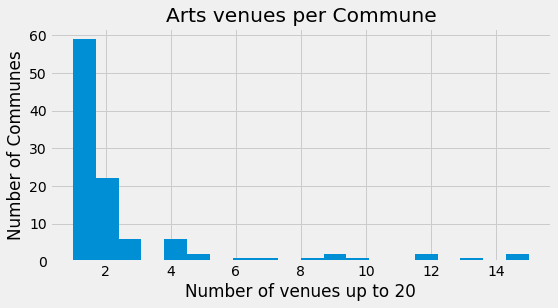

In [106]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(lux_venues_arts.groupby("Locality").count()["Venue"], bins=20)
#labels = ax.get_xticklabels()
plt.style.use('fivethirtyeight')
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.set(title = "Arts venues per Commune", xlabel = "Number of venues up to 20", ylabel = "Number of Communes")
plt.show()

In [279]:
print("Number of Arts venues identified: %d" %(lux_venues_arts.shape[0]))
lux_venues_arts.head()

Number of Arts venues identified: 271


,Locality,Locality Latitude,Locality Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Val
0,Alzingen,49.570519,6.165731,Fête de l'Amitié 2016,49.572330,6.155848,Amphitheater,1
1,Assel,49.554831,6.316817,AnnVinck.com,49.554658,6.326087,Art Gallery,1
2,Bech-Kleinmacher,49.531946,6.350399,Centre Albaach,49.528773,6.350563,Performing Arts Venue,1
3,Bech-Kleinmacher,49.531946,6.350399,"Musée folklorique et viticole ""A Possen""",49.528850,6.354110,History Museum,1
4,Belvaux,49.512146,5.933280,Artikuss,49.514707,5.927817,Performing Arts Venue,1


In [109]:
print('There are {} unique arts venue categories.'.format(len(lux_venues_arts['Venue Category'].unique())))

There are 26 unique arts venue categories.


#### Select Top 10 popular Arts venue types per commune

In [204]:
ShowTop10Venues(tab_arts).head()

,Commune,Venue 1,Venue 2,Venue 3,Venue 4,Venue 5,Venue 6,Venue 7,Venue 8,Venue 9,Venue 10
0,Alzingen,Amphitheater,,,,,,,,,
1,Assel,Art Gallery,,,,,,,,,
2,BELAIR,Art Gallery,Circus,Theater,Street Art,Concert Hall,Comedy Club,,,,
3,BONNEVOIE-NORD/VERLORENKOST,Science Museum,Rock Club,Public Art,Performing Arts Venue,Museum,History Museum,,,,
4,BONNEVOIE-SUD,Performing Arts Venue,Public Art,Concert Hall,,,,,,,


#### K-Means clustering of Luxembourg communes for Arts venues

In [ ]:
# set number of clusters
kclusters_arts = 5
# run k-means clustering
kmeans_arts = KMeans(n_clusters=kclusters_arts, random_state=100).fit(tab_arts)
tab_arts["cluster"] = kmeans_arts.labels_

#### Number of Communes per cluster, with Arts venues

In [285]:
pd.DataFrame({"Cluster": np.unique(kmeans_arts.labels_, return_counts = True)[0], "Numbers of Communes": np.unique(kmeans_arts.labels_, return_counts = True)[1]})

,Cluster,Numbers of Communes
0,0,11
1,1,19
2,2,17
3,3,8
4,4,51


#### Cluster Map of Luxembourg Arts venues

In [223]:
render_cluster_Map(kclusters_arts, tab_arts, lux_venues_arts)

#### Matrix of top 10 Arts venue types per cluster

In [213]:
gettop10venues(lux_venues_arts, kmeans_arts.labels_)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Venue 1,Concert Hall,Music Venue,Performing Arts Venue,Art Gallery,History Museum
Venue 2,Theater,Indie Movie Theater,History Museum,,Museum
Venue 3,Performing Arts Venue,Racecourse,Music Venue,,Theater
Venue 4,Multiplex,Performing Arts Venue,Science Museum,,Art Gallery
Venue 5,Mini Golf,Museum,Public Art,,Performing Arts Venue
Venue 6,Art Museum,Mini Golf,Country Dance Club,,Music Venue
Venue 7,,,Concert Hall,,Movie Theater
Venue 8,,,,,Science Museum
Venue 9,,,,,Public Art
Venue 10,,,,,Outdoor Sculpture


### Results

  We managed to identify clusters of Luxembourg communes per Outdoors venues in radius 1km from center of the communes. Only 286 communes out of total 586 communes in Luxembourg have Outdours venues. This clusters can be basically named by the first element in the cluster (most frequently used type of venues), such as __Gym, Campground, Plaza, Park, Farm, Soccer Field, Playground, Trail, Stables__.
  
  For the Arts venues we identified 5 commune clusters, such as __Concert Hall,	Music Venue, Performing Arts Venue,	Art Gallery, History Museum__. Only 106 communes have Arts of venues in Luxembourg (according to Foursquare service).
 
 It is possible to click on the clustered Map on a commune and see the popup frame appeared with the list of venues inside. So, it is easy to check out the venues available in the commune (but filtered up to maximum 20 venues per commune).   

### Discussion

As K-means clustering algorithm is non-deterministic, we can get a different result with different settings (e.g. when *random_state* value is different).
But, after many runs, it was found, that the picture will change slightly, so the clusters are reshuffled in order (0,1,2,3...), but set of leading Venue Categories (Venue1, Venue 2) will not change.    

### Conclusion

In our example, it was found that cluster analysis provides acceptable results when communes have different variety of venues, so we can identify a basis for clustering. In our case, far not all communes have similar set of Outdoors venues and Arts venues. So, this situation works well for the purpose of the clustering. 
In case when set of venues from commune to commune differs not so much, we get poor clustering performance. Such a case has place with Shop and Food categories of venues, as in such a developed country as Luxembourg, such categories of venues are widely represented across all the country.